In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import scipy.stats
# import math

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from sklearn.svm import LinearSVC

from sklearn.preprocessing import Imputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
# from sklearn.metrics import r2_score

%matplotlib inline

From the dataset documentation, columns are labeled like so:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

In [3]:
url_path = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
column_names = ['id', 'clump_thickness', 'size_uniformity', 'shape_uniformity', 'marginal_adhesion',
                'epithel_size', 'bare_nuclei', 'bland_chroma', 'normal_nucl', 'mitoses', 'malignant']
df_raw = pd.read_csv(url_path, header=None, names=column_names)
df_raw.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithel_size,bare_nuclei,bland_chroma,normal_nucl,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                   699 non-null int64
clump_thickness      699 non-null int64
size_uniformity      699 non-null int64
shape_uniformity     699 non-null int64
marginal_adhesion    699 non-null int64
epithel_size         699 non-null int64
bare_nuclei          699 non-null object
bland_chroma         699 non-null int64
normal_nucl          699 non-null int64
mitoses              699 non-null int64
malignant            699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [5]:
df_raw.bare_nuclei.value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

The dataset documentation said there were some question marks in the data! Since we need to keep as much data as possible, let's impute the median values.

In [6]:
# Since the stupid question mark makes the column into dtype: object,
# finding the median is a bit of a pain with Pandas. I'm doing it this way.
list_for_median = []
for each in df_raw.bare_nuclei:
    try:
        list_for_median.append(int(each))
    except:
        pass
bare_nuclei_median = int(np.median(list_for_median))

df_raw.loc[:, 'bare_nuclei'].replace('?', bare_nuclei_median, inplace=True)
df_raw.loc[:, 'bare_nuclei'] = df_raw['bare_nuclei'].astype(str).astype(int)
df_raw.bare_nuclei.describe()

count    699.000000
mean       3.486409
std        3.621929
min        1.000000
25%        1.000000
50%        1.000000
75%        5.000000
max       10.000000
Name: bare_nuclei, dtype: float64

In [7]:
df_raw.bare_nuclei.value_counts()

1     418
10    132
5      30
2      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

There, the question marks are all gone and now we have dtype: int64.

In [8]:
# Check for imbalanced classes. We are good here.
df_raw.malignant.value_counts()

2    458
4    241
Name: malignant, dtype: int64

In [9]:
df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,699.0,1.071704e+06,617095.729819,61634.0,870688.5,1171710.0,1238298.0,13454352.0
clump_thickness,699.0,4.417740e+00,2.815741,1.0,2.0,4.0,6.0,10.0
size_uniformity,699.0,3.134478e+00,3.051459,1.0,1.0,1.0,5.0,10.0
shape_uniformity,699.0,3.207439e+00,2.971913,1.0,1.0,1.0,5.0,10.0
marginal_adhesion,699.0,2.806867e+00,2.855379,1.0,1.0,1.0,4.0,10.0
epithel_size,699.0,3.216023e+00,2.214300,1.0,2.0,2.0,4.0,10.0
bare_nuclei,699.0,3.486409e+00,3.621929,1.0,1.0,1.0,5.0,10.0
bland_chroma,699.0,3.437768e+00,2.438364,1.0,2.0,3.0,5.0,10.0
normal_nucl,699.0,2.866953e+00,3.053634,1.0,1.0,1.0,4.0,10.0
mitoses,699.0,1.589413e+00,1.715078,1.0,1.0,1.0,1.0,10.0


In [10]:
# Check for missing data. We are good here, too.
df_raw.isnull().sum()

id                   0
clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithel_size         0
bare_nuclei          0
bland_chroma         0
normal_nucl          0
mitoses              0
malignant            0
dtype: int64

In [11]:
for i in range(len(df_raw)):
    if df_raw.bare_nuclei.loc[i] == 0:
        print(i)

In [12]:
# Make new dataframe for feature creation and modification
df_features = df_raw.copy()

# Modify class index to 0,1 instead of 2,4
df_features.loc[:, 'malignant'] = ((df_raw['malignant'] / 2) -1).astype(int)
df_features.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithel_size,bare_nuclei,bland_chroma,normal_nucl,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


It looks like this dataset is already very clean, but very small. We will have to be sure to avoid overfitting, so I think it would be wise to pick our best algortithm using cross validation.

Let's explore some features, shall we?

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


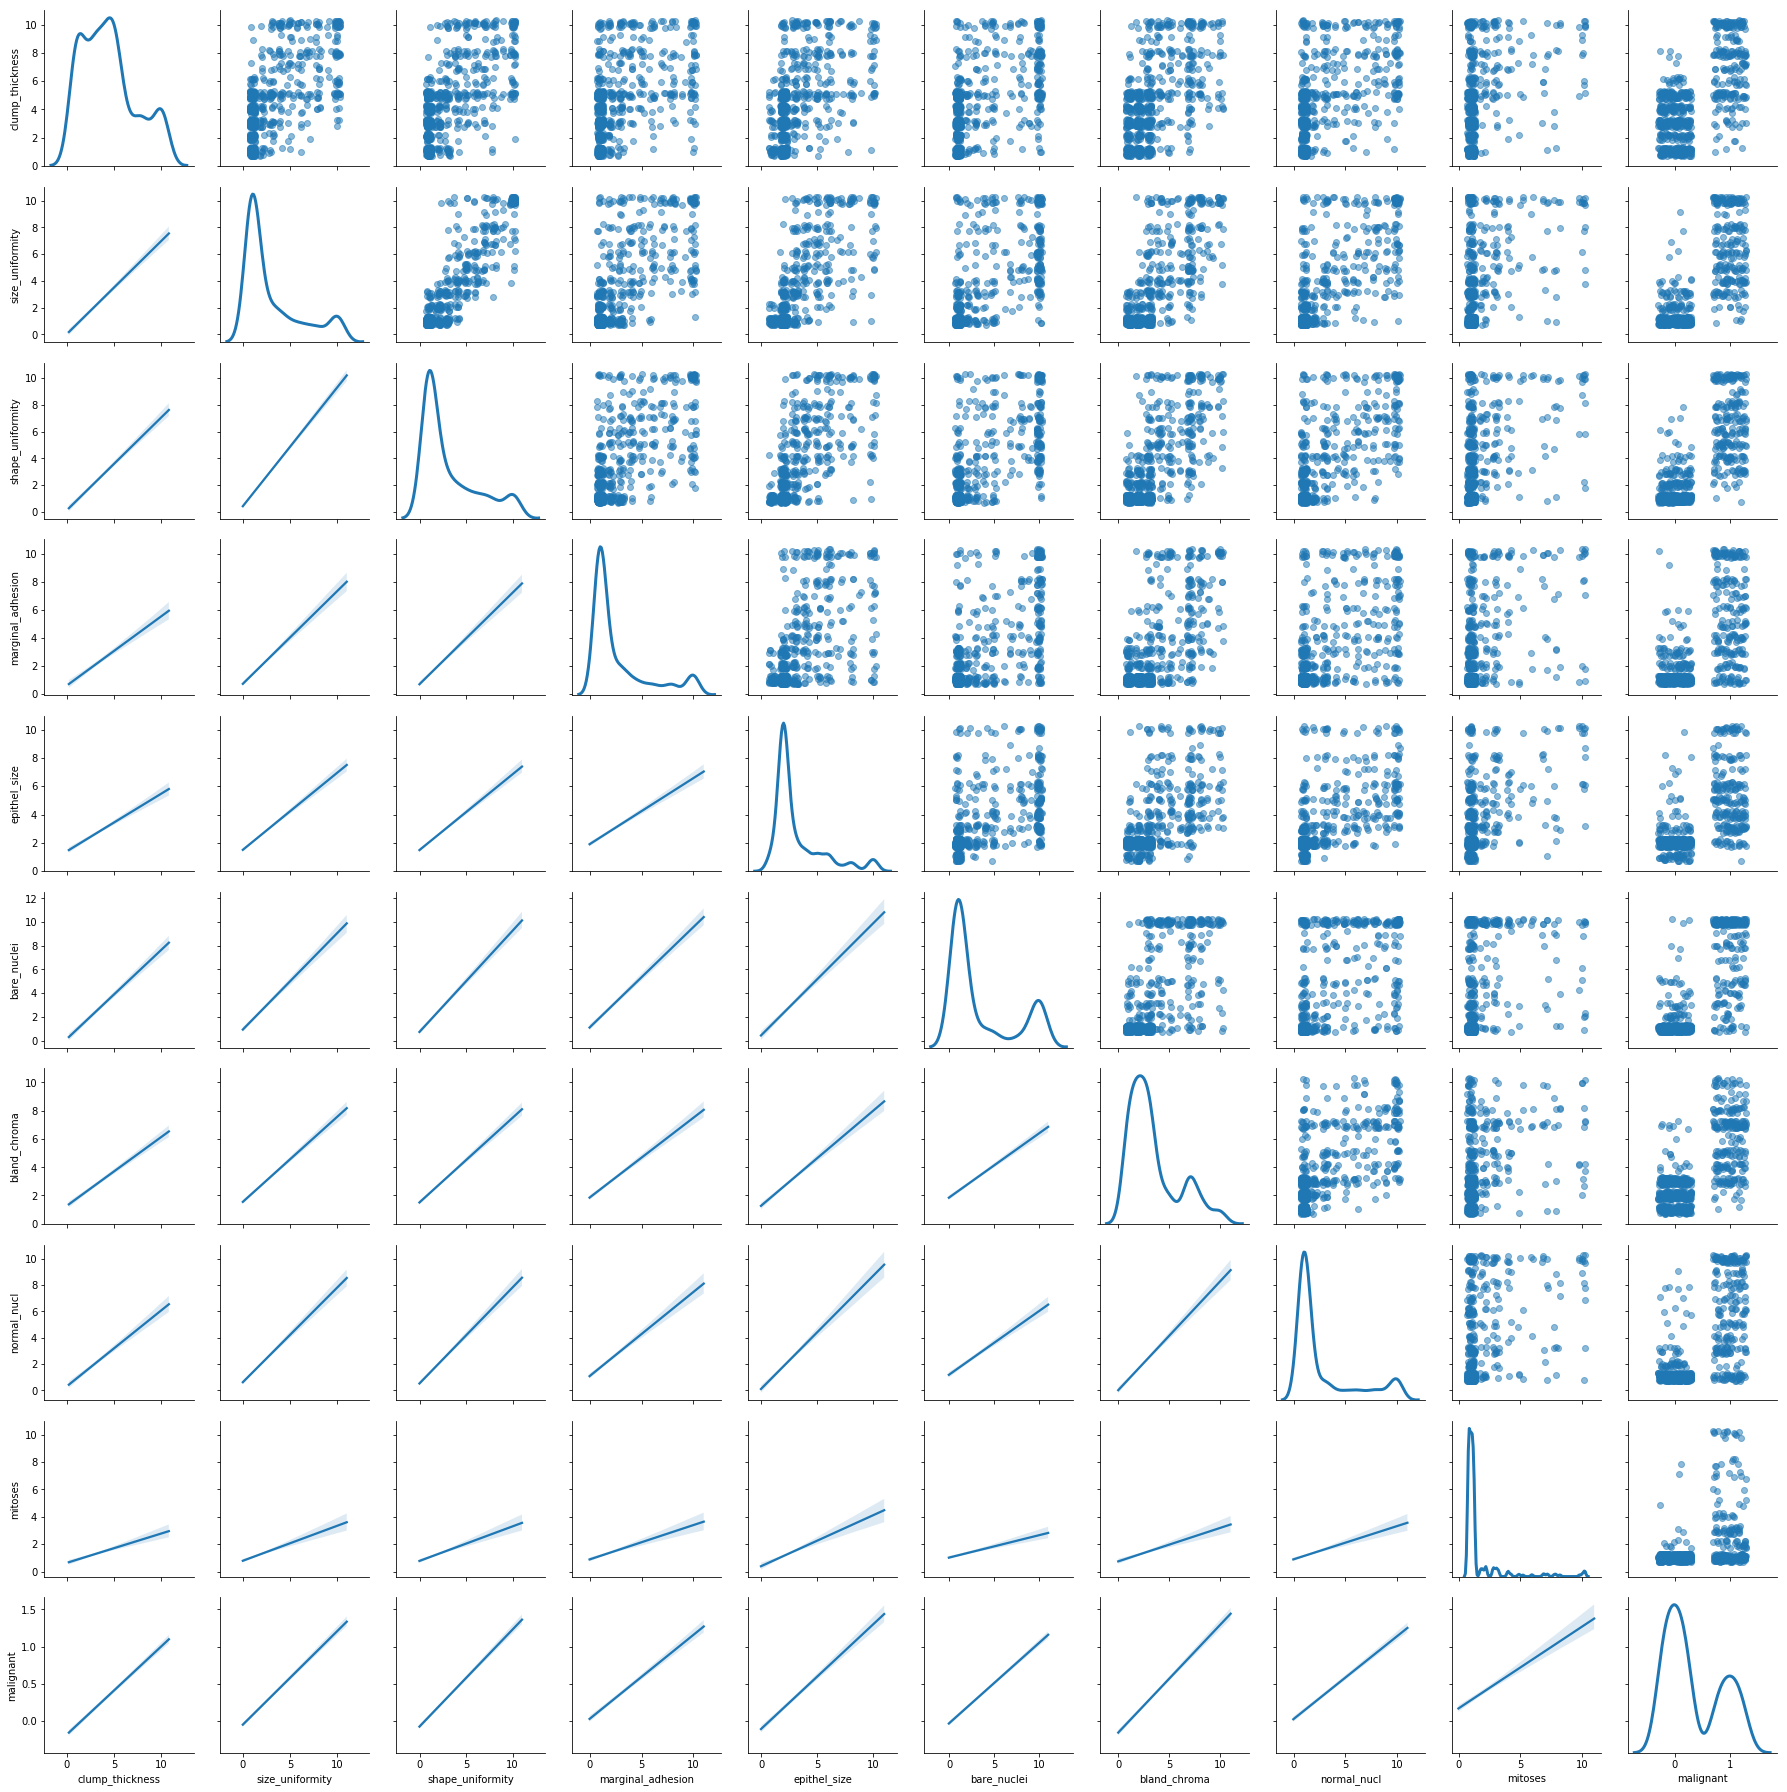

In [30]:
# Make a copy of the data to add jitter to and plot.
df_jittered = df_features.loc[:, 'clump_thickness':'malignant']
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

An interesting thing to note here is that on the far right, where malignant column lines up with each feature, we can clearly see that most of the features are separated into malignant and non-malignant groups. The bland_chroma feature has, according to my naked eye, the strongest separation. For this feature, anything above ~3 is a strong indicator of a malignant growth. I think that this dataset will be able to give us a very strong estimator for malignant tumors.

However, it is important to keep in mind that for this type of application we will want a very high recall. In fact, a recall of 100% would be desireable in order to avoid false negative classifications. If a patient who had cancer was told that they didn't have cancer, it could mean the difference between life and death. On the other hand, a false positive is fine, because a human life is not in danger in that case.

In addition, we should eliminate some of the features with high (multi?) collinearity so that we can extract the most important features from our classifier. Otherwise, our model will be unstable.

FLow Chart: Linear SVC, then KNeighbors, then SVC and Ensemble methods

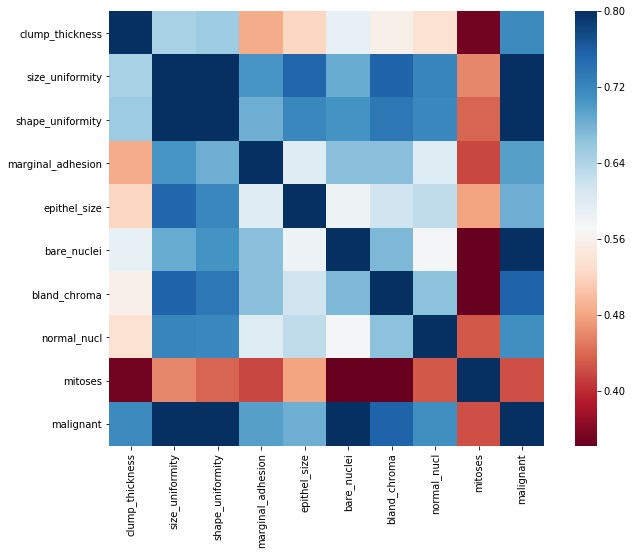

In [33]:
# Make the correlation matrix.
corrmat = df_features.drop('id', 1).corr()
# print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(11, 8))
sns.color_palette("RdBu", n_colors=7)

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="RdBu")
plt.show()
# Heatmaps are a great way to get a quick visual read on a big correlation matrix.

# Try to match the correlation numbers to the scatterplots above to get a 
# sense of what each magnitude of correlation can look like.


From this plot, we can see that size and shape uniformity are very highly correlated to each other and to malignant tumors. We can also see that mitoses has the lowest correlation to malignant

In [15]:
X = df_features.drop(['id', 'malignant'], 1)
y = df_features.malignant

# Linear SVC

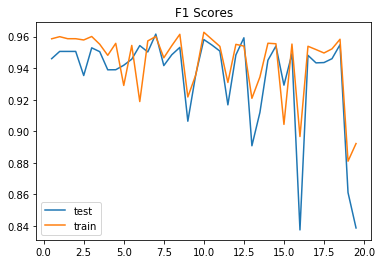

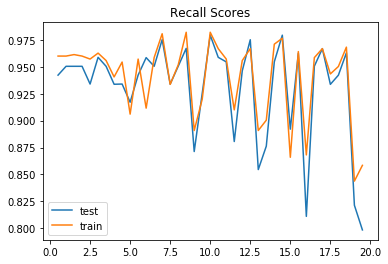

In [16]:
cross_val_scores = []
best_i = None

i_start, i_stop, i_step = .5, 20, .5
for i in np.arange(i_start, i_stop, i_step):
    lin_svc = LinearSVC(C=i)
    cross_val_scores.append(cross_validate(lin_svc, X, y, cv=4, scoring=['f1', 'recall'], return_train_score=True))

    
test_f1 = []
train_f1 = []
test_recall = []
train_recall = []
for scores in cross_val_scores:
    test_f1.append(scores['test_f1'].mean())
    train_f1.append(scores['train_f1'].mean())
    test_recall.append(scores['test_recall'].mean())
    train_recall.append(scores['train_recall'].mean())


    
plt.figure()
plt.title('F1 Scores')
plt.plot(np.arange(i_start, i_stop, i_step), test_f1, label='test')
plt.plot(np.arange(i_start, i_stop, i_step), train_f1, label='train')
plt.legend()

plt.figure()
plt.title('Recall Scores')
plt.plot(np.arange(i_start, i_stop, i_step), test_recall, label='test')
plt.plot(np.arange(i_start, i_stop, i_step), train_recall, label='train')
plt.legend()

plt.show()


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Utility function to report best scores
# I got this directly from the sklearn example for random search
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Initialize the knn algo
knn = KNeighborsClassifier(algorithm='auto')

param_dist = {"n_neighbors" : sp_randint(1, 11),
              "leaf_size" : sp_randint(10, 40),
              "p" : sp_randint(1, 10)}

n_iter_search = 50
random_search = RandomizedSearchCV(knn, param_distributions=param_dist,
                                  n_iter=n_iter_search, n_jobs=-1,
                                  scoring='f1')



random_search.fit(X, y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.951 (std: 0.024)
Parameters: {'leaf_size': 15, 'n_neighbors': 3, 'p': 9}

Model with rank: 1
Mean validation score: 0.951 (std: 0.024)
Parameters: {'leaf_size': 17, 'n_neighbors': 3, 'p': 6}

Model with rank: 1
Mean validation score: 0.951 (std: 0.024)
Parameters: {'leaf_size': 31, 'n_neighbors': 3, 'p': 6}

Model with rank: 1
Mean validation score: 0.951 (std: 0.024)
Parameters: {'leaf_size': 32, 'n_neighbors': 3, 'p': 9}



In [36]:
from sklearn.svm import SVC

# Initialize the knn algo
clf = SVC()

param_dist = {"C" : sp_randint(1, 11),
              "gamma" : sp_randint(10, 40)}

n_iter_search = 50
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                  n_iter=n_iter_search, n_jobs=-1)

random_search.fit(X,y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 7, 'gamma': 38}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 4, 'gamma': 26}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 10, 'gamma': 18}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 2, 'gamma': 32}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 10, 'gamma': 10}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 6, 'gamma': 28}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 5, 'gamma': 24}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 1, 'gamma': 21}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 9, 'gamma': 17}

Model with rank: 1
Mean validation score: 0.695 (std: 0.029)
Parameters: {'C': 2, 'gamma': 23}

Model with rank: 1
Mean validation sco